Actions each agent have to decide between: Leave or Stay 

In [59]:
import numpy as np

class Agent: 
    def __init__(self, music_taste = 1, strategy = 1, nr_concerts = int, festival_duration=int, dynamic_strategy=str):
        self.music_taste = music_taste
        self.dist_from_stage = 0
        self.position_utility = 0
        self.waiting_utility_history = np.zeros(festival_duration)
        self.waited_time = 0
        self.strategy = strategy
        self.position_utility_history = np.zeros(festival_duration)
        self.concert_history = np.ones(festival_duration, dtype=int)*(nr_concerts-1)
        self.concert_history[0] = 0 #start at first concert 
        if not isinstance(strategy, str):
            self.time_to_leave = strategy
        else:
            self.time_to_leave = 5
        self.dynamic_strategy = dynamic_strategy
    
class Concert:
    def __init__(self, len_rows = int, music_type = 1, capacity = 10, duration = int, nr_of_agents = int):
        self.len_rows = len_rows
        self.music_type = music_type
        self.nr_agents = 0
        self.nr_waiting_agents = 0
        self.capacity = capacity
        self.nr_rows = np.ceil(capacity/len_rows)
        self.duration = duration #timesteps
        self.agents = np.zeros(nr_of_agents)

    def add_agent(self):
        self.nr_agents += 1

def get_placement_utility(concert):
    placement_factor = 5
    #continuing using sigmoid
    #fullness = concert.nr_agents / concert.capacity
    #sigmoid_x = 1 - fullness
    #k = 10 #steepness of sigomid
    #center = 0.5 #[0,1] with 0.1 happy crowd and 0.9 happy front row
    #utility = placement_factor * 1 / ( 1 + np.exp(-k*(sigmoid_x- center)))

    #stepwise by which row the agent is in, sensitive to concert row length
    dist_from_stage = np.floor((concert.nr_agents) / concert.len_rows)
    utility = placement_factor * (concert.nr_rows - dist_from_stage) / concert.nr_rows
    return utility, dist_from_stage

def get_waiting_utility():
    waiting_factor = 1
    utility = -1 * waiting_factor
    return utility



Dynamic strategies depend on where the agent is currently placed

In [60]:
def get_dynamic_action(agent, nr_rows):
    new_time_to_leave = agent.time_to_leave #same time as last round

    # If in the lower half it goeas one timestep earlier than before, if in front half it
    # stayes as long as possible
    if (agent.dynamic_strategy == 'Slow Improver'):
        default_time_to_leave = 5
        if (agent.dist_from_stage > nr_rows / 3): # needs to go earlier to get a better place
            if agent.time_to_leave > 0: #it is possible to go earlier next time
                new_time_to_leave = agent.time_to_leave - 1
        else: #returns to default time to leave
            new_time_to_leave = default_time_to_leave
        return new_time_to_leave

    # If in the lower half it goeas one timestep earlier than before, if in front half it goes
    # one timestep later than before
    if (agent.dynamic_strategy == 'Slow Adjuster'):
        if (agent.dist_from_stage > nr_rows / 3): # needs to go earlier to get a better place
            if agent.time_to_leave > 0: #it is possible to go earlier next time
                new_time_to_leave = agent.time_to_leave - 1
            else:
                new_time_to_leave = 1
        else: # it is in the forn half, then it can stay a bit longer    
            if agent.time_to_leave < 5: #
                new_time_to_leave = agent.time_to_leave + 1
            else: 
                new_time_to_leave = 5
        return new_time_to_leave

    # Wants to get as far in front in concerets as possible, and stays as long as possible if 
    # in good position, that is it risks the next concert
    if (agent.dynamic_strategy == 'Risk-Taker'):
        default_time_to_leave = 5
        if (agent.dist_from_stage > nr_rows / 3): # needs to go earlier to get a better place
            new_time_to_leave = 1
        else: # happy at the front
            new_time_to_leave = default_time_to_leave
        return new_time_to_leave

    # Hates to wait, but just same strategy as to never leave early
    if (agent.dynamic_strategy == 'Hate To Wait'):
        default_time_to_leave = 5
        if (agent.waited_time < -1): #It qeueued for more than one timestep to this concert
            new_time_to_leave = 5
        else:
            new_time_to_leave = default_time_to_leave
        return new_time_to_leave

Bigger functions used in simulation

In [61]:
def move_agent_to_next_concert(agent, idx, current_concert, next_concert, timestep, global_time):
    timesteps_left = current_concert.duration-timestep
    # Fill up agent's waiting utilities until the next concert
    for k in range(0,timesteps_left-1):
        agent.waiting_utility_history[global_time+k] = -1#get_waiting_utility()
        agent.waited_time -= 1
    
    # Find position utility at next concert, add to history
    position_utility, dist_from_stage = get_placement_utility(next_concert)
    agent.position_utility = position_utility
    agent.dist_from_stage = dist_from_stage
    agent.position_utility_history[global_time + timesteps_left-1] = position_utility

    # Populate the next concert
    next_concert.add_agent() 
    next_concert.agents[idx] = 1

Inintialize variables

In [62]:
nr_of_agents = 1000
nr_concerts = 20
nr_rows = nr_of_agents*0.1
concert_duration = 5
festival_duration = nr_concerts*concert_duration


# Available dynamic strategies
defined_dynamic_startegies = ['Slow Improver', 'Slow Adjuster', 'Risk-Taker', 'Hate To Wait']
#strategies = [1, 2, 3, 4, 5]
#strategies = [1, 2, 3, 4, 5, 'Slow Improver', 'Slow Adjuster', 'Risk-Taker']
#strategies = [3,4,"Risk-Taker"]
strategies = ['Slow Improver', 'Slow Adjuster', 'Risk-Taker']

nr_of_strategies = len(strategies)

probabilities = []
dynamic_strategies = []
for strategy in strategies:
    if type(strategy) == str:
        if strategy not in defined_dynamic_startegies:
            raise print("Incorrect dynamic strategy: ", strategy)

    probabilities.append(1/len(strategies))
    if type(strategy) == int:
        dynamic_strategies.append('-')
    else:
        dynamic_strategies.append(strategy)

#probabilities = [0.4, 0.4, 0.1, 0.1]


In [63]:
def initialize_festival(probabilities):
    agents = []
    concerts = []

    for _ in range (nr_of_agents):
        strategy_idx = np.random.choice(len(strategies), p=probabilities)
        strategy_sample = strategies[strategy_idx]
        if (type(strategy_sample) == str):
            agent = Agent(strategy = strategy_sample, 
                        nr_concerts=nr_concerts, festival_duration = festival_duration, 
                        dynamic_strategy=strategy_sample)
        else: 
            agent = Agent(strategy = strategy_sample, 
                        nr_concerts=nr_concerts, festival_duration = festival_duration, 
                        dynamic_strategy='-')
        agents.append(agent)

    for _ in range(nr_concerts):
        concert = Concert(capacity = nr_of_agents, len_rows=nr_of_agents/nr_rows,
                        duration = concert_duration, nr_of_agents = nr_of_agents)
        concerts.append(concert)

    #Add all agents to the starting concerts in a random order
    shuffled_indices = np.random.permutation(nr_of_agents)
    for i in range (nr_of_agents):
        idx = shuffled_indices[i]
        position_utility = 0 #Starting utility is zero
        concerts[0].add_agent() 
        concerts[0].agents[idx] = 1
        agents[idx].position_utility = position_utility
        concerts[0].add_agent() 

    return agents, concerts

In [64]:
def simulate_one_festival(agents, concerts):

    global_time = 0
    for concert_idx in range(0,len(concerts)-1):
        current_concert = concerts[concert_idx]
        next_concert = concerts[concert_idx + 1]

        if (concert_idx > 0):
            for agent in agents:
                if (agent.dynamic_strategy != '-'): #it has a dynamic strategy
                    new_time_to_leave = get_dynamic_action(agent, current_concert.nr_rows)
                    agent.time_to_leave = new_time_to_leave
                agent.waited_time = 0

        for timestep in range(0,current_concert.duration):
            # Update time
            global_time += 1
            shuffled_indices = np.random.permutation(nr_of_agents)
            for j in range (nr_of_agents):
                idx = shuffled_indices[j]
                
                if (current_concert.agents[idx] == 0):  
                    # Not attending the concert 
                    continue
                
                # Get action
                if (agents[idx].time_to_leave == timestep+1):
                    action = 'leave'
                else: 
                    action = 'stay'
                
                if (action == 'leave'):
                    # Leave current concert
                    current_concert.agents[idx] = 0
                    
                    for k in range(0,current_concert.duration-timestep):
                        #Update agent's concert history
                        agents[idx].concert_history[global_time + k] = concert_idx + 1

                    # Set agent up at the next concert
                    move_agent_to_next_concert(agents[idx], idx, current_concert, next_concert, timestep, global_time)
                    
                else: #they stay at the concert one more time step
                    # Improve position utility
                    agents[idx].position_utility_history[global_time] = agents[idx].position_utility
                    
                    #Update agent's concert history
                    agents[idx].concert_history[global_time] = concert_idx 
                    
        # Let all agents stay at the last concert
        if (concert_idx == nr_concerts-2):
            for agent in agents:
                for k in range(0,next_concert.duration):
                    agent.position_utility_history[global_time+k] = agent.position_utility

    return agents

In [65]:
agents, concerts = initialize_festival(probabilities)

agents = simulate_one_festival(agents, concerts)

idx = 0
print("Strategy: ", agents[idx].strategy)
print("Total time steps: ", len(agents[idx].concert_history), ", Concert duration: ", concert_duration, ", Nr of concerts: ", len(concerts))
print("Arena at each timestp: ", agents[idx].concert_history)
print("Waiting utility history: ", agents[idx].waiting_utility_history)
print("Position utility history: ", agents[idx].position_utility_history)


Strategy:  Slow Adjuster
Total time steps:  100 , Concert duration:  5 , Nr of concerts:  20
Arena at each timestp:  [ 0  0  0  0  0  1  1  1  1  1  2  2  2  2  3  3  3  3  4  4  4  4  5  5
  5  5  5  5  6  6  6  6  7  7  7  7  7  7  8  8  8  8  9  9  9  9 10 10
 10 10 10 10 10 10 10 10 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19
 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19
 19 19 19 19]
Waiting utility history:  [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.
 -1. -1.  0.  0. -1. -1. -1.  0.  0.  0. -1. -1.  0.  0. -1. -1. -1.  0.
  0.  0. -1. -1.  0.  0. -1. -1. -1.  0. -1. -1. -1. -1.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Position utility history:  [0.   0.   0.   0.   0.   3.9  3.9  3.9  3.9  3.9  0.95 0.95 0.95 0.95
 0.   2.   2.   2.   0.   0.   2.75 2.75 0.   

Some basic plots of how utility change with time

In [66]:
#preprocess data for plotting
for agent in agents:
    agent.waiting_utility_history = np.cumsum(agent.waiting_utility_history)
    agent.position_utility_history = np.cumsum(agent.position_utility_history)

print("Waiting utility history: ", agents[idx].waiting_utility_history)
print("Position utility history: ", agents[idx].position_utility_history)

Waiting utility history:  [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  -1.  -1.  -1.  -1.  -2.  -3.  -3.  -3.  -4.  -5.  -6.  -6.  -6.  -6.
  -7.  -8.  -8.  -8.  -9. -10. -11. -11. -11. -11. -12. -13. -13. -13.
 -14. -15. -16. -16. -17. -18. -19. -20. -20. -20. -20. -20. -20. -20.
 -20. -20. -20. -20. -20. -20. -20. -20. -20. -20. -20. -20. -20. -20.
 -20. -20. -20. -20. -20. -20. -20. -20. -20. -20. -20. -20. -20. -20.
 -20. -20. -20. -20. -20. -20. -20. -20. -20. -20. -20. -20. -20. -20.
 -20. -20.]
Position utility history:  [  0.     0.     0.     0.     0.     3.9    7.8   11.7   15.6   19.5
  20.45  21.4   22.35  23.3   23.3   25.3   27.3   29.3   29.3   29.3
  32.05  34.8   34.8   34.8   34.8   39.15  43.5   47.85  47.85  47.85
  49.45  51.05  51.05  51.05  51.05  54.5   57.95  61.4   61.4   61.4
  62.8   64.2   64.2   64.2   64.2   67.1   67.1   67.1   67.1   67.1
  70.2   73.3   76.4   79.5   82.6   85.7   85.7   85.7   85.7   85.7
  85.7   85.7   8

Proportions of each class [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]


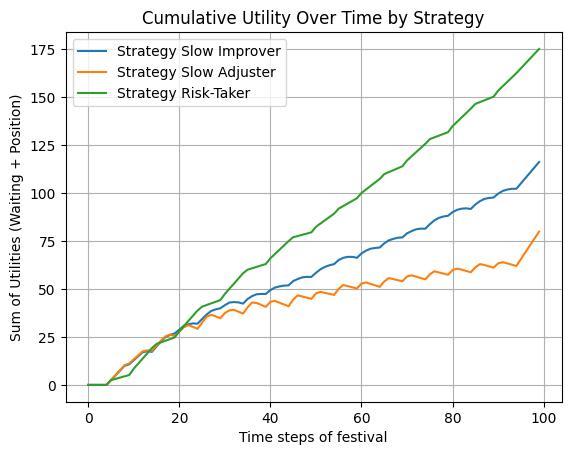

In [67]:
import matplotlib.pyplot as plt
import numpy as np

# Group agents by strategy
agents_by_strategy = {strategy: [agent for agent in agents if agent.strategy == strategy] for strategy in strategies}

# Initialize sum of utilities for each strategy
sum_utilities = {strategy: np.zeros(festival_duration) for strategy in strategies}

# Calculate cumulative utilities for each strategy
for strategy, agent_list in agents_by_strategy.items():
    for agent in agent_list:
        sum_utilities[strategy] += agent.waiting_utility_history + agent.position_utility_history
    if len(agent_list) > 0:  # Normalize only if there are agents with this strategy
        sum_utilities[strategy] /= len(agent_list)

# Plot the utilities
timesteps = np.arange(festival_duration)
for strategy, utility in sum_utilities.items():
    plt.plot(timesteps, utility, label=f"Strategy {strategy}")

print("Proportions of each class", probabilities)

# Configure the plot
plt.xlabel("Time steps of festival")
plt.ylabel("Sum of Utilities (Waiting + Position)")
plt.title("Cumulative Utility Over Time by Strategy")
plt.legend()
plt.grid(True)
plt.show()


In [68]:
#from graphs import BarGraph
# A = np.zeros([nr_concerts, int(festival_duration)])

# agent_concert = []

# # Make dataset
# for agent in agents:
#     agent_concert.append(agent.concert_history)

# for agent in agent_concert:
#     t = 0
#     for i in agent:
#         A[i, t] += 1
#         t += 1

# graph = BarGraph(A)
# graph.plot_data(5)

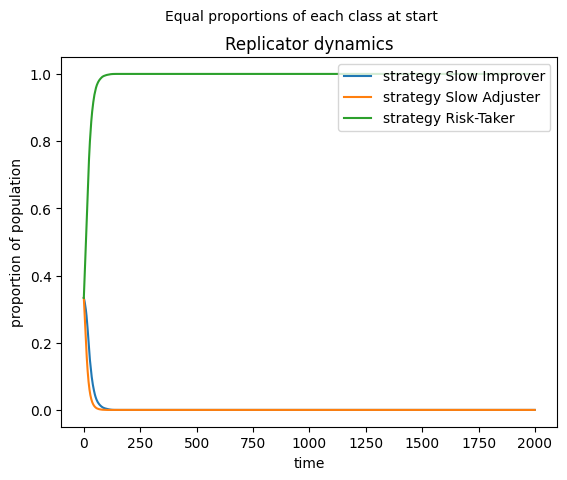

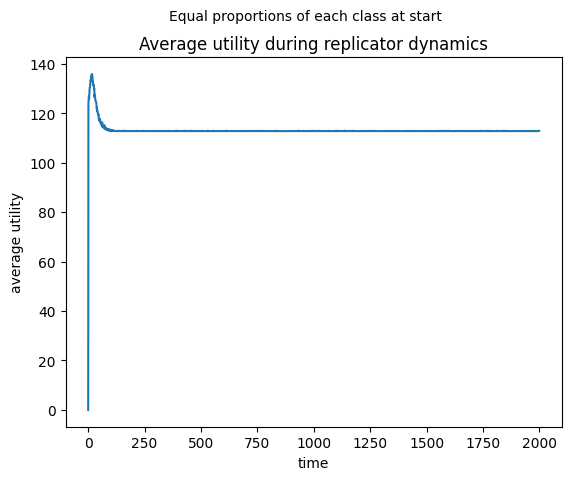

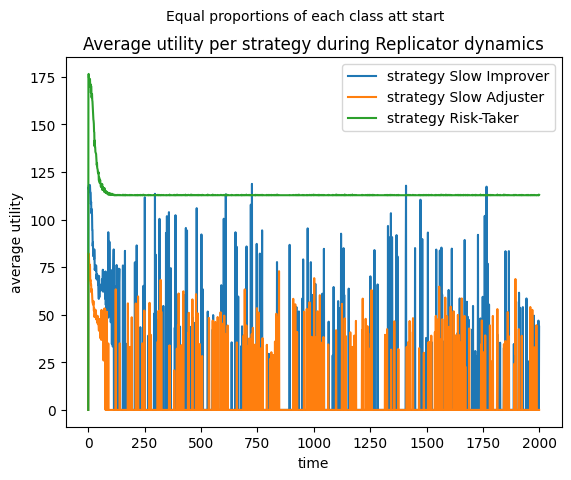

In [ ]:
from datetime import datetime

#probabilities = [0.05, 0.05, 0.05, 0.05, 0.8]
#probabilities = [0.24, 0.04, 0.24, 0.24, 0.24]
#probabilities = [0.1,0.8,0.1]
#probabilities = [0.02, 0.98, 0, 0, 0]

equal_probabilities = True

if equal_probabilities:
    probabilities = np.ones(nr_of_strategies) / nr_of_strategies

nr_timesteps = 2000
nr_iterations = 1
r_value = 0.001 # what value?
population_proportions = np.zeros((nr_of_strategies, nr_timesteps))

population_proportions[:,0] = probabilities
average_utility_over_time = np.zeros(nr_timesteps)
average_utility_per_strategy_over_time = np.zeros((nr_of_strategies, nr_timesteps))

for t in range(1,nr_timesteps):

    # initilize utilities
    average_utility = 0
    average_utility_per_strategy = np.zeros(nr_of_strategies)
    agents_per_strategy_total_count = np.zeros(nr_of_strategies) # use to compute average utility per strategy

    for iter in range(nr_iterations):
        
        # initialize festival
        agents, concerts = initialize_festival(population_proportions[:,t-1])

        # simulate festival
        agents = simulate_one_festival(agents, concerts)

        # get average utilities for all agents
        for agent in agents:
            agent.waiting_utility_history = np.cumsum(agent.waiting_utility_history)
            agent.position_utility_history = np.cumsum(agent.position_utility_history)

        sum_utility_iter = 0
        for agent in agents:
            sum_utility_iter += agent.position_utility_history[-1] + agent.waiting_utility_history[-1]
            #print(agent.strategy)
            #print(agent.position_utility_history[-1] + agent.waiting_utility_history[-1])
            #print()
        average_utility += sum_utility_iter / (nr_iterations*nr_of_agents)

        # get average utility for each strategy
        agents_by_strategy = {strategy: [agent for agent in agents if agent.strategy == strategy] for strategy in strategies}
        sum_utility_per_strategy = np.zeros(nr_of_strategies)

        for strategy, agent_list in agents_by_strategy.items():
            strategy_index = strategies.index(strategy)
            #print("strategy", strategy)
            #print("strat index", strategy_index)
            #print()
            for agent in agent_list:
                sum_utility_per_strategy[strategy_index] += agent.position_utility_history[-1] + agent.waiting_utility_history[-1]
            
            #if (len(agent_list) > 0):
            #    average_utility_per_strategy[strategy - 1] = average_utility_per_strategy[strategy - 1] / len(agent_list)
            average_utility_per_strategy[strategy_index ] += sum_utility_per_strategy[strategy_index ]
            agents_per_strategy_total_count[strategy_index ] += len(agent_list)

    # compute average utility per strategy
    for i in range(nr_of_strategies):
        if agents_per_strategy_total_count[i] > 0:
            average_utility_per_strategy[i] /= agents_per_strategy_total_count[i] 

    # store average utilities
    average_utility_over_time[t] = average_utility
    average_utility_per_strategy_over_time[:,t] = average_utility_per_strategy

    #print(average_utility_per_strategy)

    # update population_proportions
    delta_population = r_value * population_proportions[:,t-1] * (average_utility_per_strategy - average_utility)
    #print(delta_population)
    population_proportions[:,t] = population_proportions[:,t-1] + delta_population

    for i, value in enumerate(population_proportions[:,t]):
        population_proportions[i,t] = np.max([0.0001, value])
        #if(population_proportions[i,t] < 0.001): # commented out to allow for comeback
        #   population_proportions[i,t] = 0
    
    scale_factor = 1 / sum(population_proportions[:,t])

    population_proportions[:,t] *= scale_factor

# print evolution
fig, axes = plt.subplots(1,1)
timesteps_plot = np.arange(nr_timesteps)
for i in range(nr_of_strategies):
    axes.plot(timesteps_plot, population_proportions[i,:], label = "strategy " + str(strategies[i]))

# plot replicator dynamics
axes.set_xlabel("time")
axes.set_ylabel("proportion of population")
axes.legend(loc = "upper right")
axes.set_title("Replicator dynamics")
if equal_probabilities:
    fig.suptitle("Equal proportions of each class at start", fontsize = 10)  
else:
    fig.suptitle("Proportions of Each Class at start: " + str(np.round(probabilities,2)), size = 10)
plt.savefig("evolution_" + datetime.now().strftime("%m%d%Y_%H%M%S") + ".pdf", format="pdf", bbox_inches="tight")
plt.show()

# plot utility over time
fig, axes = plt.subplots(1,1)
axes.plot(timesteps_plot, average_utility_over_time)
axes.set_xlabel("time")
axes.set_ylabel("average utility")
axes.set_title("Average utility during replicator dynamics")
if equal_probabilities:
    fig.suptitle("Equal proportions of each class at start", fontsize = 10)  
else:
    fig.suptitle("Proportions of Each Class at start: " + str(np.round(probabilities,2)), size = 10)
plt.savefig("evolution_utility_tot.pdf", format="pdf", bbox_inches="tight")
plt.show()

# plot average utlity over time per strategy
fig, axes = plt.subplots(1,1)
for i in range(nr_of_strategies):
    axes.plot(timesteps_plot, average_utility_per_strategy_over_time[i,:], label = "strategy " + str(strategies[i]))
axes.set_xlabel("time")
axes.set_ylabel("average utility")
axes.legend(loc = "upper right")
axes.set_title("Average utility per strategy during Replicator dynamics")
if equal_probabilities:
    fig.suptitle("Equal proportions of each class at start", fontsize = 10)  
else:
    fig.suptitle("Proportions of Each Class at start: " + str(np.round(probabilities,2)), size = 10)
plt.show()
#plt.savefig("evolution_utility_per_strat.pdf", format="pdf", bbox_inches="tight")


In [70]:
strategies = [1, 2, 3, 4, 5, 'Risk-Taker','Slow Improver', 'Slow Adjuster']
strategy = 1
print(strategies.index(strategy))

0
